In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np

In [35]:
df_raw = pd.read_csv('dataset/male_players.csv')
df = df_raw.drop(['Unnamed: 0','URL', 'Gender','GK'],axis=1)
df.head()

,Name,Nation,Club,Position,Age,Overall,Pace,Shooting,Passing,Dribbling,...,Sliding,Jumping,Stamina,Strength,Aggression,Att work rate,Def work rate,Preferred foot,Weak foot,Skill moves
0,Kylian Mbappé,France,Paris SG,ST,24,91,97,90,80,93,...,32,88,88,77,64,High,Low,Right,4,5
1,Erling Haaland,Norway,Manchester City,ST,23,91,89,93,66,79,...,29,93,76,93,87,High,Medium,Left,3,3
2,Kevin De Bruyne,Belgium,Manchester City,CM,32,91,72,88,94,86,...,53,72,88,74,75,High,Medium,Right,5,4
3,Lionel Messi,Argentina,Inter Miami CF,CF,36,90,80,87,90,96,...,24,71,70,68,44,Low,Low,Left,4,4
4,Karim Benzema,France,Al Ittihad,CF,35,90,79,88,83,87,...,18,85,82,82,63,Medium,Medium,Right,4,4


In [36]:
df['Position'].unique()

array(['ST', 'CM', 'CF', 'GK', 'RW', 'CB', 'LW', 'CDM', 'CAM', 'RM', 'LB',
       'RB', 'LM', 'LWB', 'RWB'], dtype=object)

### Jika tidak ada player yang mengisi posisi pada formasi?
pisahkan data menjadi 3 bagian lapangan. Depan, Tengah, Belakang <br>
Pemain depan: ['ST', 'CF', 'RW', 'LW']<br>
Pemain tengah: ['CM', 'CDM', 'CAM', 'RM', 'LB', 'RB', 'LM']<br>
Pemain belakang: ['GK', 'CB', 'LWB', 'RWB']


In [37]:
# Pisahkan pemain berdasarkan posisi
forwards = df[df['Position'].isin(['ST', 'CF', 'RW', 'LW'])]
midfielders = df[df['Position'].isin(['CM', 'CDM', 'CAM', 'RM', 'LM'])]
defenders = df[df['Position'].isin(['GK', 'CB', 'LB', 'RB', 'LWB', 'RWB'])]

### Genetic Algorithm

In [69]:
# Define functions
def calculate_fitness(individual, target_positions):
    fitness_value = 0
    for player, position in zip(individual, target_positions):
        if player['Position'] == position:
            fitness_value += player['Overall']
    return fitness_value

def tournament_selection(population, fitness_values, tournament_size):
    selected_parents = []
    for _ in range(len(population)):
        tournament_candidates_indices = random.sample(range(len(population)), tournament_size)
        tournament_candidates_fitness = [fitness_values[i] for i in tournament_candidates_indices]
        winner_index = tournament_candidates_indices[np.argmax(tournament_candidates_fitness)]
        selected_parents.append(population[winner_index])
    return selected_parents

def crossover(parent1, parent2, player_data):
    crossover_point = random.randint(0, len(parent1) - 1)
    child1 = parent1[:crossover_point] + parent2[crossover_point:]
    child2 = parent2[:crossover_point] + parent1[crossover_point:]
    
    # Ensure no duplicate players in children
    child1 = remove_duplicates(child1, player_data)
    child2 = remove_duplicates(child2, player_data)

    return child1, child2

def mutate(individual, player_data, mutation_rate):
    for i in range(len(individual)):
        if random.uniform(0, 1) < mutation_rate:
            new_player = random.choice(player_data)
            while new_player['Name'] in [player['Name'] for player in individual]:
                new_player = random.choice(player_data)
            individual[i] = new_player
    return individual

def remove_duplicates(individual, player_data):
    seen_names = set()
    unique_individual = []
    for player in individual:
        if player['Name'] not in seen_names:
            unique_individual.append(player)
            seen_names.add(player['Name'])
    while len(unique_individual) < len(individual):
        new_player = random.choice(player_data)
        while new_player['Name'] in seen_names:
            new_player = random.choice(player_data)
        unique_individual.append(new_player)
        seen_names.add(new_player['Name'])
    return unique_individual

def genetic_algorithm(population, player_data, target_positions, generations, tournament_size, crossover_rate, mutation_rate, pop_size):
    temp_result = []
    best_individual = None
    best_fitness = float('-inf')

    for generation in range(generations):
        fitness_values = [calculate_fitness(individual, target_positions) for individual in population]

        # Keep track of the best individual in the current generation
        max_fitness = max(fitness_values)
        if max_fitness > best_fitness:
            best_fitness = max_fitness
            best_individual = population[np.argmax(fitness_values)]

        # Tournament selection
        parents = tournament_selection(population, fitness_values, tournament_size)

        # Crossover
        children = []
        for parent1, parent2 in zip(parents[::2], parents[1::2] + [None]):
            if parent2 is not None:
                if random.uniform(0, 1) < crossover_rate:
                    child1, child2 = crossover(parent1, parent2, player_data)
                    children.append(child1)
                    children.append(child2)
                else:
                    children.append(parent1)
                    children.append(parent2)
            else:
                # Handle the case where the number of parents is odd
                children.append(parent1)

        # Mutation
        mutated_children = [mutate(child, player_data, mutation_rate) for child in children] 
        # mutated_children = [mutate(individual, player_data, mutation_rate, target_positions) for individual in children] 

        # Combine old and new populations, then select the best individuals
        combined_population = population + mutated_children
        fitness_values_combined = [calculate_fitness(individual, target_positions) for individual in combined_population]
        best_indices_combined = np.argsort(fitness_values_combined)[-pop_size:]
        population = [combined_population[i] for i in best_indices_combined]

        # Print results for each generation
        temp_result.append(best_fitness)
        # print(f"Generation {generation + 1}, Best Fitness: {best_fitness}")
    
    # Pilih individu terbaik dari populasi terakhir
    fitness_values = [calculate_fitness(individual, target_positions) for individual in population]
    best_individual_index = np.argmax(fitness_values)
    best_individual = population[best_individual_index]

    return best_individual, temp_result

### Parameter and Data Selection

In [39]:
formations = {
    "4-3-3": ['GK', 'RB', 'CB', 'CB', 'LB', 'CDM', 'CM', 'CAM', 'RW', 'CF', 'LW'],
    "4-4-2": ['GK', 'RB', 'CB', 'CB', 'LB', 'RM', 'CM', 'CM', 'LM', 'CF', 'ST'],
    "3-5-2": ['GK', 'CB', 'CB', 'CB', 'RM', 'CM', 'CDM', 'CAM', 'LM', 'CF', 'ST'],
    "4-2-3-1": ['GK', 'RB', 'CB', 'CB', 'LB', 'CDM', 'CDM', 'CAM', 'RW', 'CF', 'LW'],
    "3-4-3": ['GK', 'CB', 'CB', 'CB', 'RM', 'CM', 'CM', 'LM', 'RW', 'CF', 'LW'],
    "5-3-2": ['GK', 'CB', 'CB', 'CB', 'RWB', 'LWB', 'CM', 'CM', 'CM', 'CF', 'ST'],
    "4-1-4-1": ['GK', 'RB', 'CB', 'CB', 'LB', 'CDM', 'RM', 'CM', 'CM', 'LM', 'CF'],
    "4-5-1": ['GK', 'RB', 'CB', 'CB', 'LB', 'RM', 'CM', 'CM', 'CM', 'LM', 'CF'],
    "3-6-1": ['GK', 'CB', 'CB', 'CB', 'RM', 'CM', 'CM', 'CDM', 'CAM', 'LM', 'CF'],
    "4-3-2-1": ['GK', 'RB', 'CB', 'CB', 'LB', 'CDM', 'CM', 'CM', 'CAM', 'CAM', 'CF'],
    "4-2-2-2": ['GK', 'RB', 'CB', 'CB', 'LB', 'CDM', 'CDM', 'RM', 'LM', 'CF', 'ST'],
    "4-4-1-1": ['GK', 'RB', 'CB', 'CB', 'LB', 'RM', 'CM', 'CM', 'LM', 'CAM', 'CF'],
    "3-4-1-2": ['GK', 'CB', 'CB', 'CB', 'RM', 'CM', 'CM', 'LM', 'CAM', 'CF', 'ST'],
    "3-1-4-2": ['GK', 'CB', 'CB', 'CB', 'CDM', 'RM', 'CM', 'CM', 'LM', 'CF', 'ST'],
    "4-2-1-3": ['GK', 'RB', 'CB', 'CB', 'LB', 'CDM', 'CDM', 'CAM', 'RW', 'CF', 'LW'],
    "5-4-1": ['GK', 'CB', 'CB', 'CB', 'RWB', 'LWB', 'CM', 'CM', 'CM', 'LM', 'CF'],
    "4-1-3-2": ['GK', 'RB', 'CB', 'CB', 'LB', 'CDM', 'RM', 'CM', 'LM', 'CF', 'ST'],
    "3-3-4": ['GK', 'CB', 'CB', 'CB', 'CDM', 'CM', 'CM', 'RW', 'CF', 'ST', 'LW'],
    "4-2-4": ['GK', 'RB', 'CB', 'CB', 'LB', 'CM', 'CM', 'RW', 'CF', 'ST', 'LW'],
    "3-2-3-2": ['GK', 'CB', 'CB', 'CB', 'CDM', 'CM', 'RM', 'CAM', 'LM', 'CF', 'ST']
}
# Mengubah dict_keys ke list
formations_keys_list = list(formations.keys())

print(formations_keys_list)

['4-3-3', '4-4-2', '3-5-2', '4-2-3-1', '3-4-3', '5-3-2', '4-1-4-1', '4-5-1', '3-6-1', '4-3-2-1', '4-2-2-2', '4-4-1-1', '3-4-1-2', '3-1-4-2', '4-2-1-3', '5-4-1', '4-1-3-2', '3-3-4', '4-2-4', '3-2-3-2']


Individu Terbaik:
Name: Marc-André ter Stegen, Position: GK
Name: Jules Koundé, Position: CB
Name: Andreas Christensen, Position: CB
Name: Ronald Araujo, Position: CB
Name: Mamadou Fall, Position: CB
Name: Pedri, Position: CM
Name: Frenkie de Jong, Position: CM
Name: Oriol Romeu, Position: CDM
Name: Aleix Garrido, Position: CM
Name: Marcos Alonso, Position: LB
Name: João Félix, Position: CF


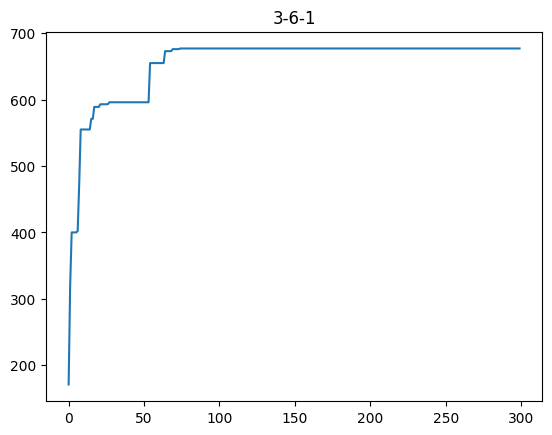

In [70]:
player_data = df[df['Club'] == 'FC Barcelona'].to_dict(orient='records')
# player_data = df.to_dict(orient='records')

# Inisialisasi populasi
pop_size = 10
population = []

for _ in range(pop_size):
    # Ambil 11 player secara acak dari player_data
    team = random.sample(player_data, 11)
    population.append(team)

# Inisialisasi populasi
initial_population = population

# Parameter algoritma genetika
team_formation = 8 # select formation
target_positions = formations[formations_keys_list[team_formation]]
generations = 300
tournament_size = 3
crossover_rate = 0.8
mutation_rate = 0.1

# Jalankan algoritma genetika
result, temp_result = genetic_algorithm(population, player_data, target_positions, generations, tournament_size, crossover_rate, mutation_rate, pop_size)

# Cetak hasil individu terbaik
print("Individu Terbaik:")
best_teams = result
for player in best_teams:
    print(f"Name: {player['Name']}, Position: {player['Position']}")
plt.plot((temp_result))
plt.title(formations_keys_list[team_formation])
plt.show()